# Summary

-----

# Imports

In [1]:
%run imports.ipynb

2016-08-12 14:23:13.894061


In [2]:
print2 = ascommon.df_tools.print2

In [3]:
NOTEBOOK_NAME = 'core_data_statistics'

# Load data

In [4]:
db = datapkg.MySQL(
    os.environ['DATAPKG_CONNECTION_STR'], 
    NOTEBOOK_NAME, 
    None, 
    echo=False)

### Load DATA

This includes both calculated (with $\Delta \Delta G$ prediction) and not calculated (without $\Delta \Delta G$ prediction).

In [5]:
with open('core_load_data/DATA.pkl', 'rb') as ifh:
    DATA = pickle.load(ifh)

### Load DATA_DF

This only includes calculated mutations (with $\Delta \Delta G$ prediction).

In [6]:
DATA_DF = pd.read_pickle('core_load_data/DATA_DF.pkl')
#DATA_DF['ddg_exp'] = DATA_DF['ddg_exp'].astype(float)

### Compare

In [7]:
DATA['cosmic'][['uniprot_id', 'uniprot_mutation']].drop_duplicates().shape

(376417, 2)

In [8]:
DATA_DF[DATA_DF['dataset'] == 'cosmic'][['uniprot_id', 'uniprot_mutation']].drop_duplicates().shape
# 376417

(376417, 2)

# DATA

In [9]:
DATA.keys()

dict_keys(['potapov_diffseqi', 'curatedprotherm_diffseqi', 'guerois_diffseqi', 'protherm_diffseqi', 'potapov', 'taipale_diffseqi', 'alascan_gpk_diffseqi', 'humsavar', 'cosmic', 'alascan_gpk', 'kellogg', 'guerois', 'clinvar', 'protherm', 'taipale', 'curatedprotherm', 'kellogg_diffseqi'])

In [10]:
tail_columns = ['humsavar', 'clinvar', 'cosmic']

columns_all = (
    sorted(c for c in DATA.keys() if c not in tail_columns) +
    tail_columns
)
assert not set(DATA.keys()) - set(columns_all)

columns_nodiffseqi = (
    sorted(c for c in DATA.keys() if not c.endswith('_diffseqi') and c not in tail_columns) +
    tail_columns
)

columns_training_set = ['protherm', 'taipale', 'humsavar', 'clinvar', 'cosmic']

## Dataset overlap

### All columns

In [11]:
counts = {}
df_out = pd.DataFrame(columns=columns_all, index=columns_all, dtype=float)

for dataset_1 in columns_all:
    # print(dataset_1)
    df_1 = DATA[dataset_1].copy()
    # df_1 = df[df['dataset'] == dataset_1]
    mutation_set_1 = set(df_1['uniprot_id'] + '.' + df_1['uniprot_mutation'])
    counts[dataset_1] = len(mutation_set_1)
    for dataset_2 in columns_all:
        # print('\t', dataset_2)
        df_2 = DATA[dataset_2].copy()
        # df_2 = df[df['dataset'] == dataset_2]
        mutation_set_2 = set(df_2['uniprot_id'] + '.' + df_2['uniprot_mutation'])
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df_out.loc[dataset_1, dataset_2] = frac_covered * 100.0
df_out.index = ['{}\n(n = {:.0f})'.format(x, counts[x]) for x in df_out.index]

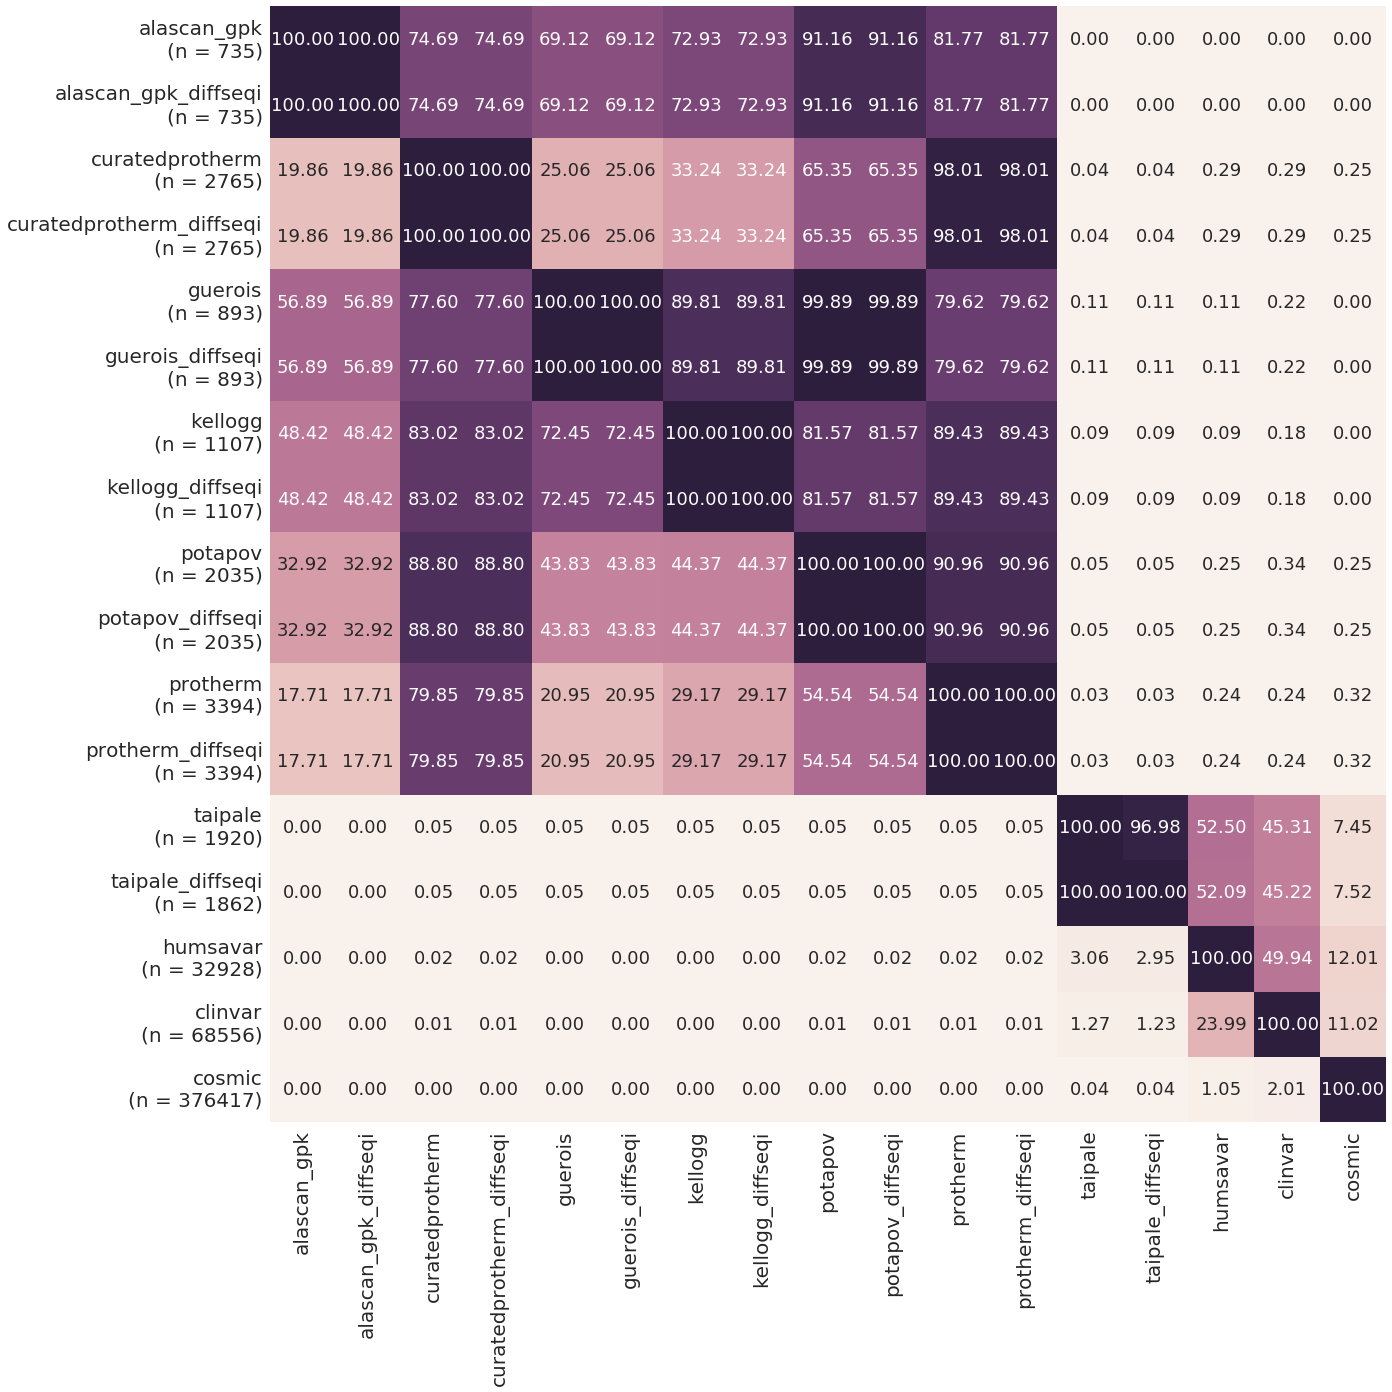

In [12]:
fg, ax = plt.subplots(figsize=(24, 20))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})

### No diffseqi

In [13]:
counts = {}
df_out = pd.DataFrame(columns=columns_nodiffseqi, index=columns_nodiffseqi, dtype=float)

for dataset_1 in columns_nodiffseqi:
    # print(dataset_1)
    df_1 = DATA[dataset_1]
    # df_1 = df[df['dataset'] == dataset_1]
    mutation_set_1 = set(df_1['uniprot_id'] + '.' + df_1['uniprot_mutation'])
    counts[dataset_1] = len(mutation_set_1)
    for dataset_2 in columns_nodiffseqi:
        # print('\t', dataset_2)
        df_2 = DATA[dataset_2]
        # df_2 = df[df['dataset'] == dataset_2]
        mutation_set_2 = set(df_2['uniprot_id'] + '.' + df_2['uniprot_mutation'])
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df_out.loc[dataset_1, dataset_2] = frac_covered * 100.0

# Format row and column names
df_out.index = ['{}\n(n = {:.0f})'.format(x, counts[x]) for x in df_out.index]
df_out.columns = df_out.columns

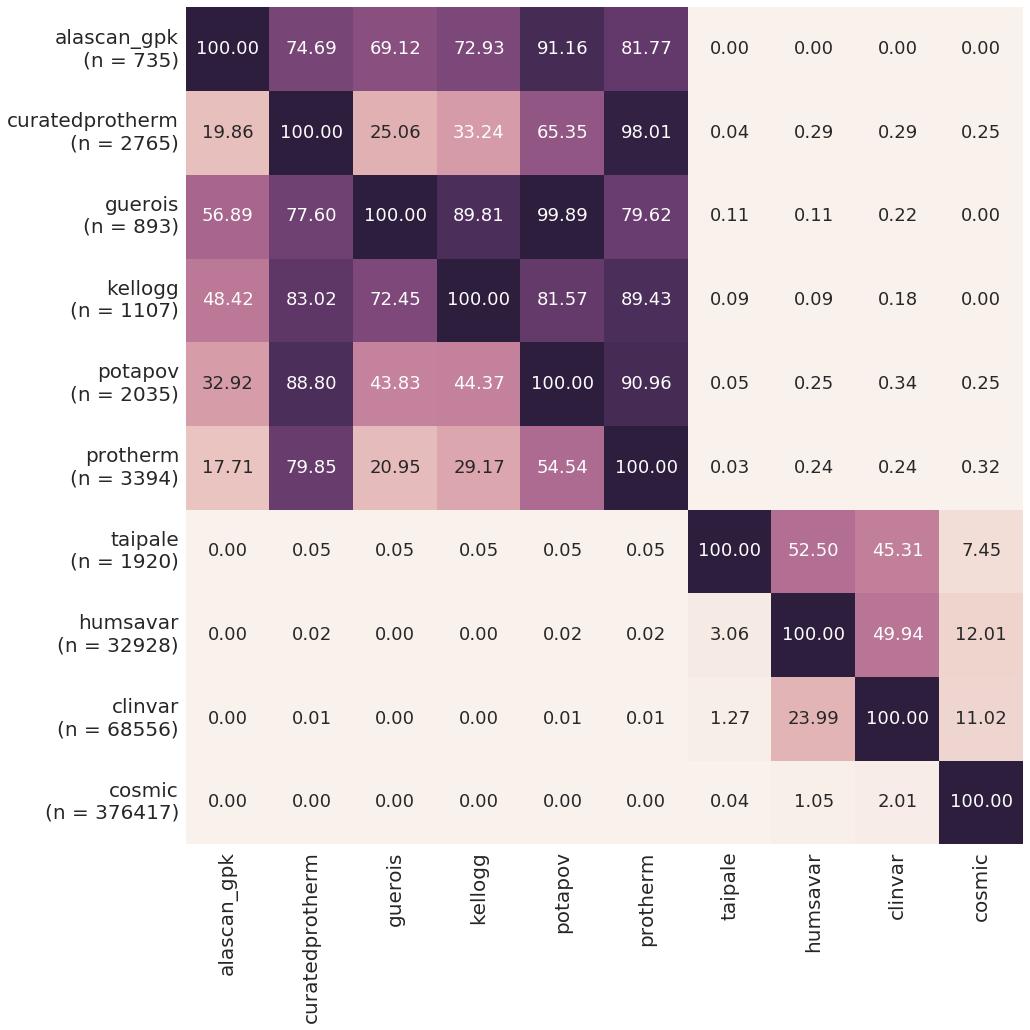

In [14]:
fg, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})

## Correlations

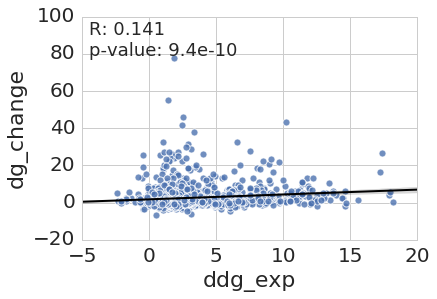

In [15]:
# Some validation to make sure that we 
fg, ax = plt.subplots()
ascommon.plotting_tools.make_plot_with_corr(
    x='ddg_exp', 
    y='dg_change',
    data=DATA['taipale'][['ddg_exp', 'dg_change']].drop_duplicates(), 
    ax=ax,
    corr_type='pearson'
)

### Correlation with Foldx

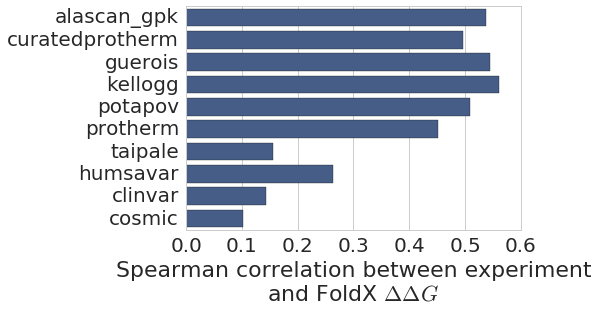

In [16]:
corrs = OrderedDict()
for table_name in columns_nodiffseqi:
    df = DATA[table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')

### Correlation with Provean

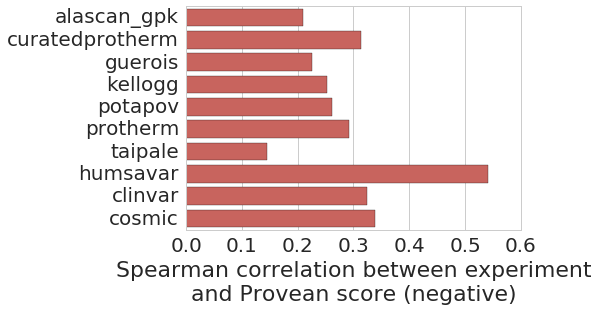

In [17]:
corrs = OrderedDict()
for table_name in columns_nodiffseqi:
    df = DATA[table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    else:
        df['ddg_exp'] = df['ddg_exp'].abs()
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')

# DATA_DF

In [18]:
DATA_DF.head()

,alignment_coverage,alignment_def,alignment_filename,alignment_identity,alignment_score,alignment_subdefs,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id,chain,chain_modeller,cis_bond_change,cis_bond_wt,dataset,db,ddg,ddg_exp,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_def,domain_end,domain_start,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def,model_errors,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation_errors,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdbfam_idx,pdbfam_name,pfam_clan,pfam_names,protein_existence,protein_name,provean_score,sasa_score,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id,uniprot_domain_id_old,uniprot_id,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt
0,100.0,67:156,P00648_1b27A.aln,100.0,1.0,67:156,-0.11,63.13,-0.02,-55.36,1b27A00,A,A,0.0,0.0,protherm,sp,0.829500,0.09,NaN,NaN,-0.58,41.52,0.0,0.0,48:157,157,48,0.0,0.0,0.00,-7.04,0.0,0.36,0.0,0.0,-0.28,151.88,-0.85,63.15,None,0.00,-1.96,2014-12-22 21:05:37,-1.0,100.0,0.0,0.0,48:157,None,P00648.B99990001.pdb,P00648_Q151A/MUT_RepairPDB_P00648.B99990001_1.pdb,P00648_Q151A/WT_RepairPDB_P00648.B99990001_1.pdb,2014-08-07 23:06:32,None,Q104A,-1.33777,110.0,Bacillus amyloliquefaciens,0.0,0.0,bacam/P00/64/P00648/Ribonuclease*67-156/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,1,Ribonuclease,Ribonuclease,Ribonuclease,1.0,Ribonuclease,-2.160,"120.104122279,87.543977591,49.8328050713,24.78...",0,6.0,2.0,0.78,-26.85,0.0,0.0,0.47,-158.13,-0.80,159.06,-18.0192,67.1770,2015-09-01 05:12:36,None,-0.01,13.70,24447509,NaN,P00648,Q151A,RNBR_BACAM,MMKMEGIALKKRLSWISVCLLVLVSAAGMLFSTAAKTETSSHKAHT...,0.43,-0.28,23.57,-120.88,0.0,0.0
1,100.0,67:156,P00648_1b27A.aln,100.0,1.0,67:156,-0.40,63.28,0.08,-56.00,1b27A00,A,A,0.0,0.0,protherm,sp,0.244914,1.63,NaN,NaN,-3.04,41.46,0.0,0.0,48:157,157,48,0.0,0.0,0.03,-6.92,0.0,0.36,0.0,0.0,-0.23,151.98,-1.21,63.42,None,0.00,-1.96,2014-12-22 21:05:37,-2.0,100.0,0.0,0.0,48:157,None,P00648.B99990001.pdb,P00648_I156A/MUT_RepairPDB_P00648.B99990001_1.pdb,P00648_I156A/WT_RepairPDB_P00648.B99990001_1.pdb,2014-08-07 23:03:33,None,I109A,-1.33777,110.0,Bacillus amyloliquefaciens,0.0,0.0,bacam/P00/64/P00648/Ribonuclease*67-156/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,1,Ribonuclease,Ribonuclease,Ribonuclease,1.0,Ribonuclease,-2.917,"120.104122279,87.543977591,49.8328050713,24.78...",0,0.0,2.0,0.00,-27.66,0.0,0.0,3.03,-158.81,-1.25,159.87,5.9086,13.6620,2015-09-01 05:12:36,None,-0.55,13.69,24447509,NaN,P00648,I156A,RNBR_BACAM,MMKMEGIALKKRLSWISVCLLVLVSAAGMLFSTAAKTETSSHKAHT...,1.73,-4.68,24.91,-121.42,0.0,0.0
2,100.0,67:156,P00648_1b27A.aln,100.0,1.0,67:156,-0.06,63.31,0.01,-55.95,1b27

In [19]:
DATA_DF['dataset'].drop_duplicates().tolist()

['protherm',
 'protherm_diffseqi',
 'taipale',
 'taipale_diffseqi',
 'humsavar',
 'clinvar',
 'cosmic']

In [20]:
datasets = [
    'protherm',
    'protherm_diffseqi',
    'taipale',
    'taipale_diffseqi',
    'humsavar',
    'clinvar',
    'cosmic'
]

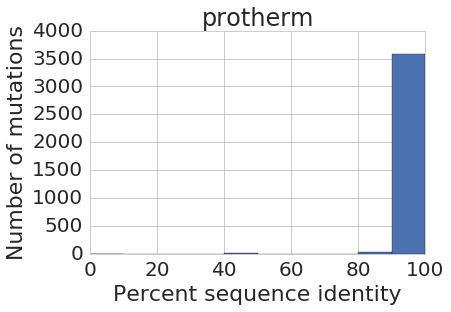

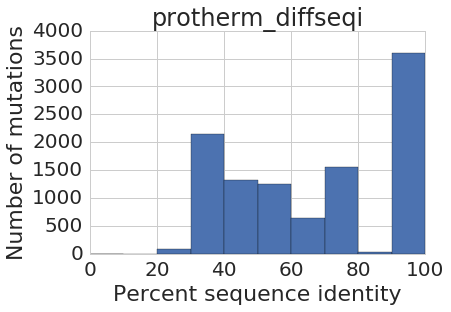

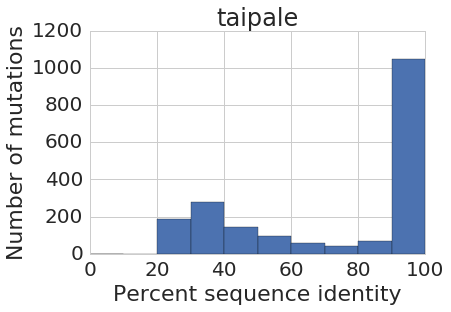

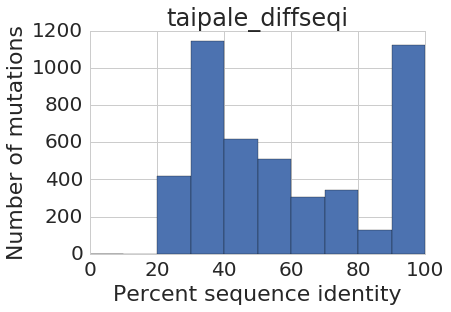

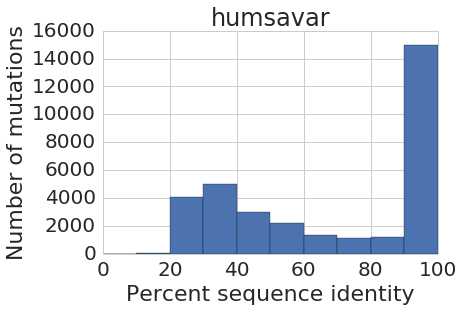

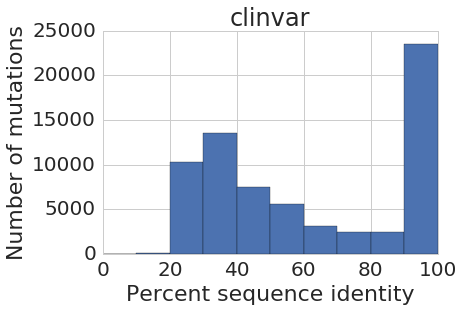

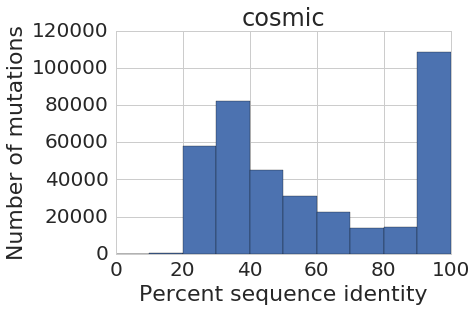

In [21]:
# Histogram sequence identities
for dataset in datasets:
    plt.figure()
    DATA_DF[DATA_DF['dataset'] == dataset]['alignment_identity'].hist(range=(0, 100), bins=10)
    plt.title(dataset)
    plt.xlabel("Percent sequence identity")
    plt.ylabel("Number of mutations")

In [22]:
columns_training_set = ['protherm', 'taipale', 'humsavar', 'clinvar', 'cosmic']

## Dataset overlap

In [23]:
counts = {}
df = DATA_DF.dropna(subset=['ddg']).copy()
df_out = pd.DataFrame(columns=columns_training_set, index=columns_training_set, dtype=float)

for dataset_1 in columns_training_set:
    # print(dataset_1)
    df_1 = df[df['dataset'] == dataset_1]
    mutation_set_1 = set(df_1['uniprot_id'] + '.' + df_1['uniprot_mutation'])
    counts[dataset_1] = len(mutation_set_1)
    for dataset_2 in columns_training_set:
        # print('\t', dataset_2)
        df_2 = df[df['dataset'] == dataset_2]
        mutation_set_2 = set(df_2['uniprot_id'] + '.' + df_2['uniprot_mutation'])
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df_out.loc[dataset_1, dataset_2] = frac_covered * 100.0
df_out.index = ['{}\n(n = {:.0f})'.format(x, counts[x]) for x in df_out.index]

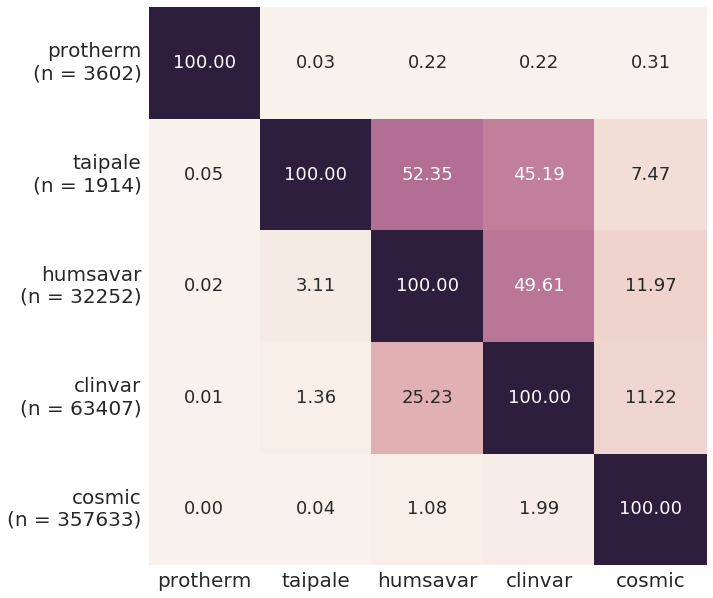

In [24]:
fg, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})
plt.yticks(rotation='horizontal')
plt.savefig(op.join(NOTEBOOK_NAME, 'training_set_overlap_final.png'), bbox_inches='tight', dpi=220)
plt.savefig(op.join(NOTEBOOK_NAME, 'training_set_overlap_final.pdf'), bbox_inches='tight')

## Correlations

### Correlation with FoldX

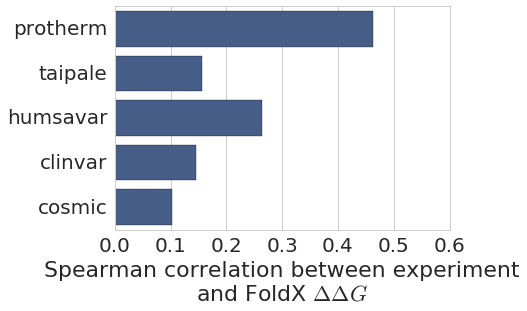

In [25]:
corrs = OrderedDict()
for table_name in columns_training_set:
    df = DATA_DF[DATA_DF['dataset'] == table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')
plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.png'), bbox_inches='tight', dpi=220)
plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.pdf'), bbox_inches='tight')

### Correlation with Provean

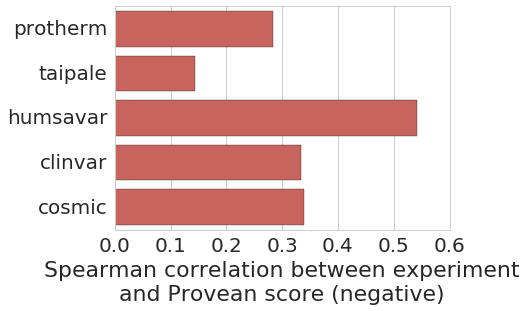

In [26]:
corrs = OrderedDict()
for table_name in columns_training_set:
    df = DATA_DF[DATA_DF['dataset'] == table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    else:
        df['ddg_exp'] = df['ddg_exp'].abs()
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')
plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.png'), bbox_inches='tight', dpi=220)
plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.pdf'), bbox_inches='tight')